In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import warnings

warnings.filterwarnings('ignore')

from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, f1_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping


In [10]:
df_train = pd.read_csv("dados_projeto_evasao_treino.csv")
df_test = pd.read_csv("dados_projeto_evasao_teste.csv")

print("Treinamento:", df_train.shape)
print("Teste:", df_test.shape)


Treinamento: (400, 37)
Teste: (100, 37)


In [11]:
# Identificação automática dos tipos
target = 'evadiu'

cat_cols = [col for col in df_train.columns if col.startswith("ds")]
num_cols = [col for col in df_train.columns if col.startswith("nr") or col.startswith("vl")]
time_cols = [col for col in df_train.columns if col.startswith("ts")]

# Confirmação
print("Variáveis categóricas:", cat_cols)
print("Variáveis numéricas:", num_cols)
print("Variáveis de tempo:", time_cols)


Variáveis categóricas: ['ds_cidade_usuario']
Variáveis numéricas: ['nr_dias_desde_primeiro_acesso', 'nr_dias_desde_ultimo_acesso', 'nr_atividades_sinalizadas', 'nr_atividades_mapeadas', 'nr_discussoes_forum_postadas', 'nr_questionarios_abandonados', 'nr_questionarios_finalizados', 'vl_medio_tempo_questionario', 'vl_medio_tempo_questionario_avaliado', 'vl_desempenho_questionario', 'nr_intervalos_uso', 'nr_dias_uso', 'vl_medio_atividade_diaria', 'vl_engajamento_usuario_por_intervalo', 'vl_engajamento_usuario_intradia', 'nr_interacoes_usuario', 'nr_dias_engajamento_discussao', 'nr_dias_engajamento_questionario', 'nr_engajamento_discussao', 'nr_engajamento_questionario', 'nr_questoes_respondidas', 'nr_questoes_corretas', 'nr_questoes_erradas', 'nr_questoes_parciais', 'vl_desempenho_usuario', 'vl_media_questoes_por_dia', 'vl_engajamento_notas', 'nr_itens_avaliados', 'nr_itens_nao_respondidos', 'vl_media_notas', 'nr_submissoes_codigo', 'vl_media_submissoes_codigo', 'vl_submissoes_por_dias_at

In [ ]:
# Criação da variável target 'evadiu'
df_train['evadiu'] = (
    ((df_train['nr_questionarios_finalizados'] < 2) & (df_train['vl_engajamento_usuario_por_intervalo'] < 0.2)) |
    (df_train['vl_media_notas'] == 0)
).astype(int)

df_test['evadiu'] = (
    ((df_test['nr_questionarios_finalizados'] < 2) & (df_test['vl_engajamento_usuario_por_intervalo'] < 0.2)) |
    (df_test['vl_media_notas'] == 0)
).astype(int)


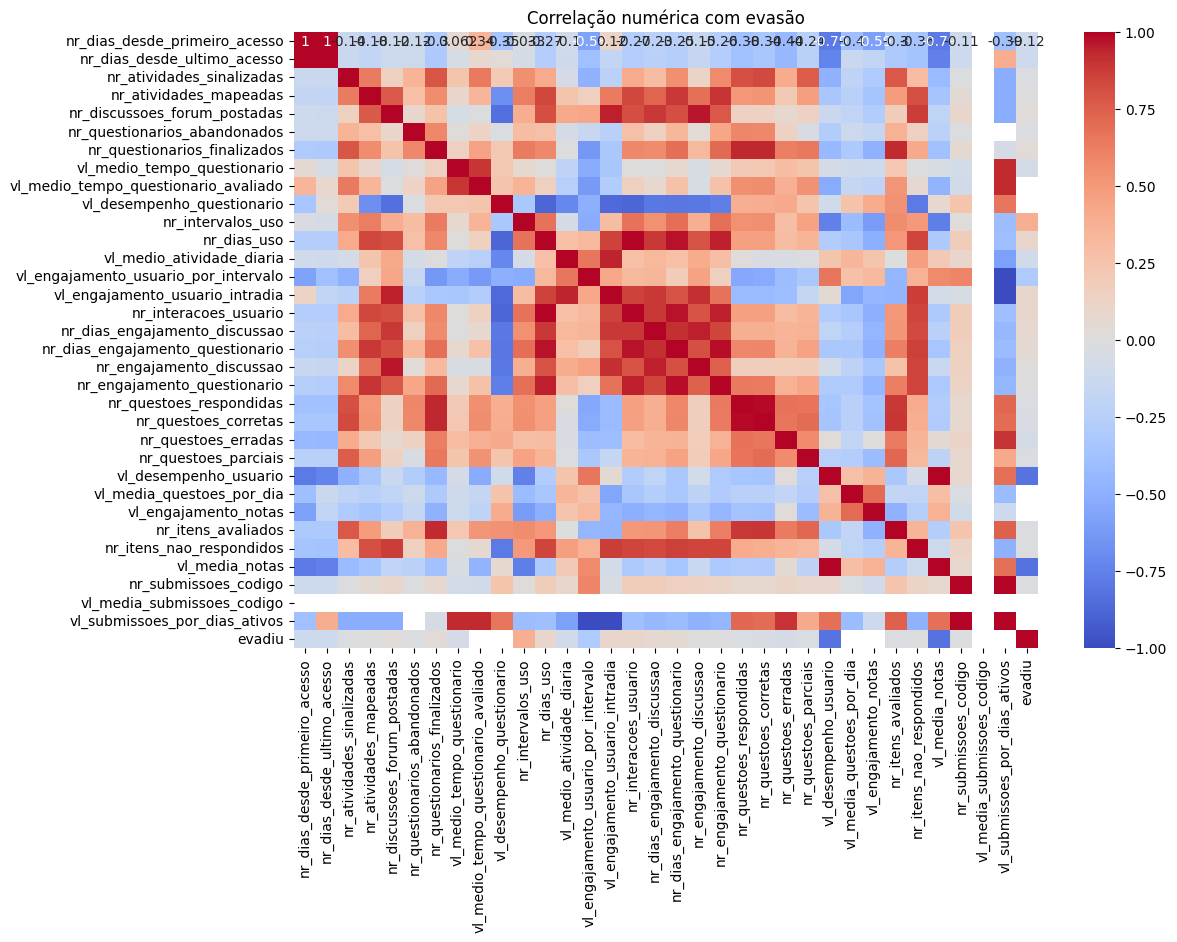

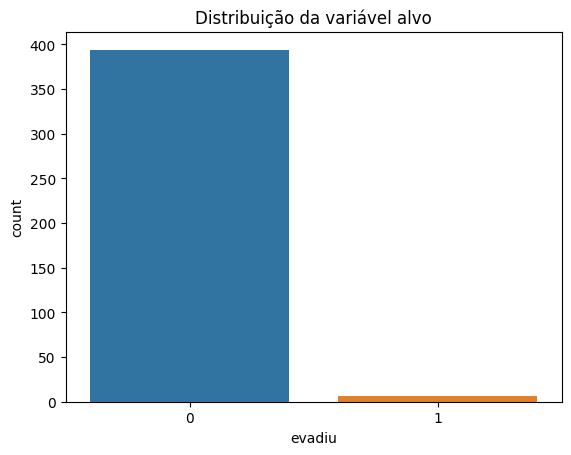

In [13]:
# Correlação
plt.figure(figsize=(12, 8))
sns.heatmap(df_train[num_cols + [target]].corr(), annot=True, cmap='coolwarm')
plt.title("Correlação numérica com evasão")
plt.show()

# Distribuição do target
sns.countplot(x=target, data=df_train)
plt.title("Distribuição da variável alvo")
plt.show()


In [14]:
# Separar dados
X_train = df_train.drop(columns=[target])
y_train = df_train[target]
X_test = df_test.drop(columns=[target])
y_test = df_test[target]

# Pipelines
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_cols),
    ('cat', cat_pipeline, cat_cols)
])


In [15]:
model_rf = Pipeline([
    ('preprocess', preprocessor),
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])

model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

print("Random Forest:")
print(classification_report(y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        99
           1       0.50      1.00      0.67         1

    accuracy                           0.99       100
   macro avg       0.75      0.99      0.83       100
weighted avg       0.99      0.99      0.99       100



In [16]:
# Transformar dados
X_train_nn = preprocessor.fit_transform(X_train)
X_test_nn = preprocessor.transform(X_test)

# Modelo
model_nn = Sequential([
    Dense(64, activation='relu', input_shape=(X_train_nn.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinamento com early stopping
es = EarlyStopping(patience=5, restore_best_weights=True)
history = model_nn.fit(X_train_nn, y_train, epochs=50, batch_size=16,
                       validation_split=0.2, callbacks=[es], verbose=0)

# Avaliação
y_pred_nn = (model_nn.predict(X_test_nn) > 0.5).astype(int)
print("Rede Neural:")
print(classification_report(y_test, y_pred_nn))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Rede Neural:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        99
           1       0.50      1.00      0.67         1

    accuracy                           0.99       100
   macro avg       0.75      0.99      0.83       100
weighted avg       0.99      0.99      0.99       100



<Figure size 640x480 with 0 Axes>

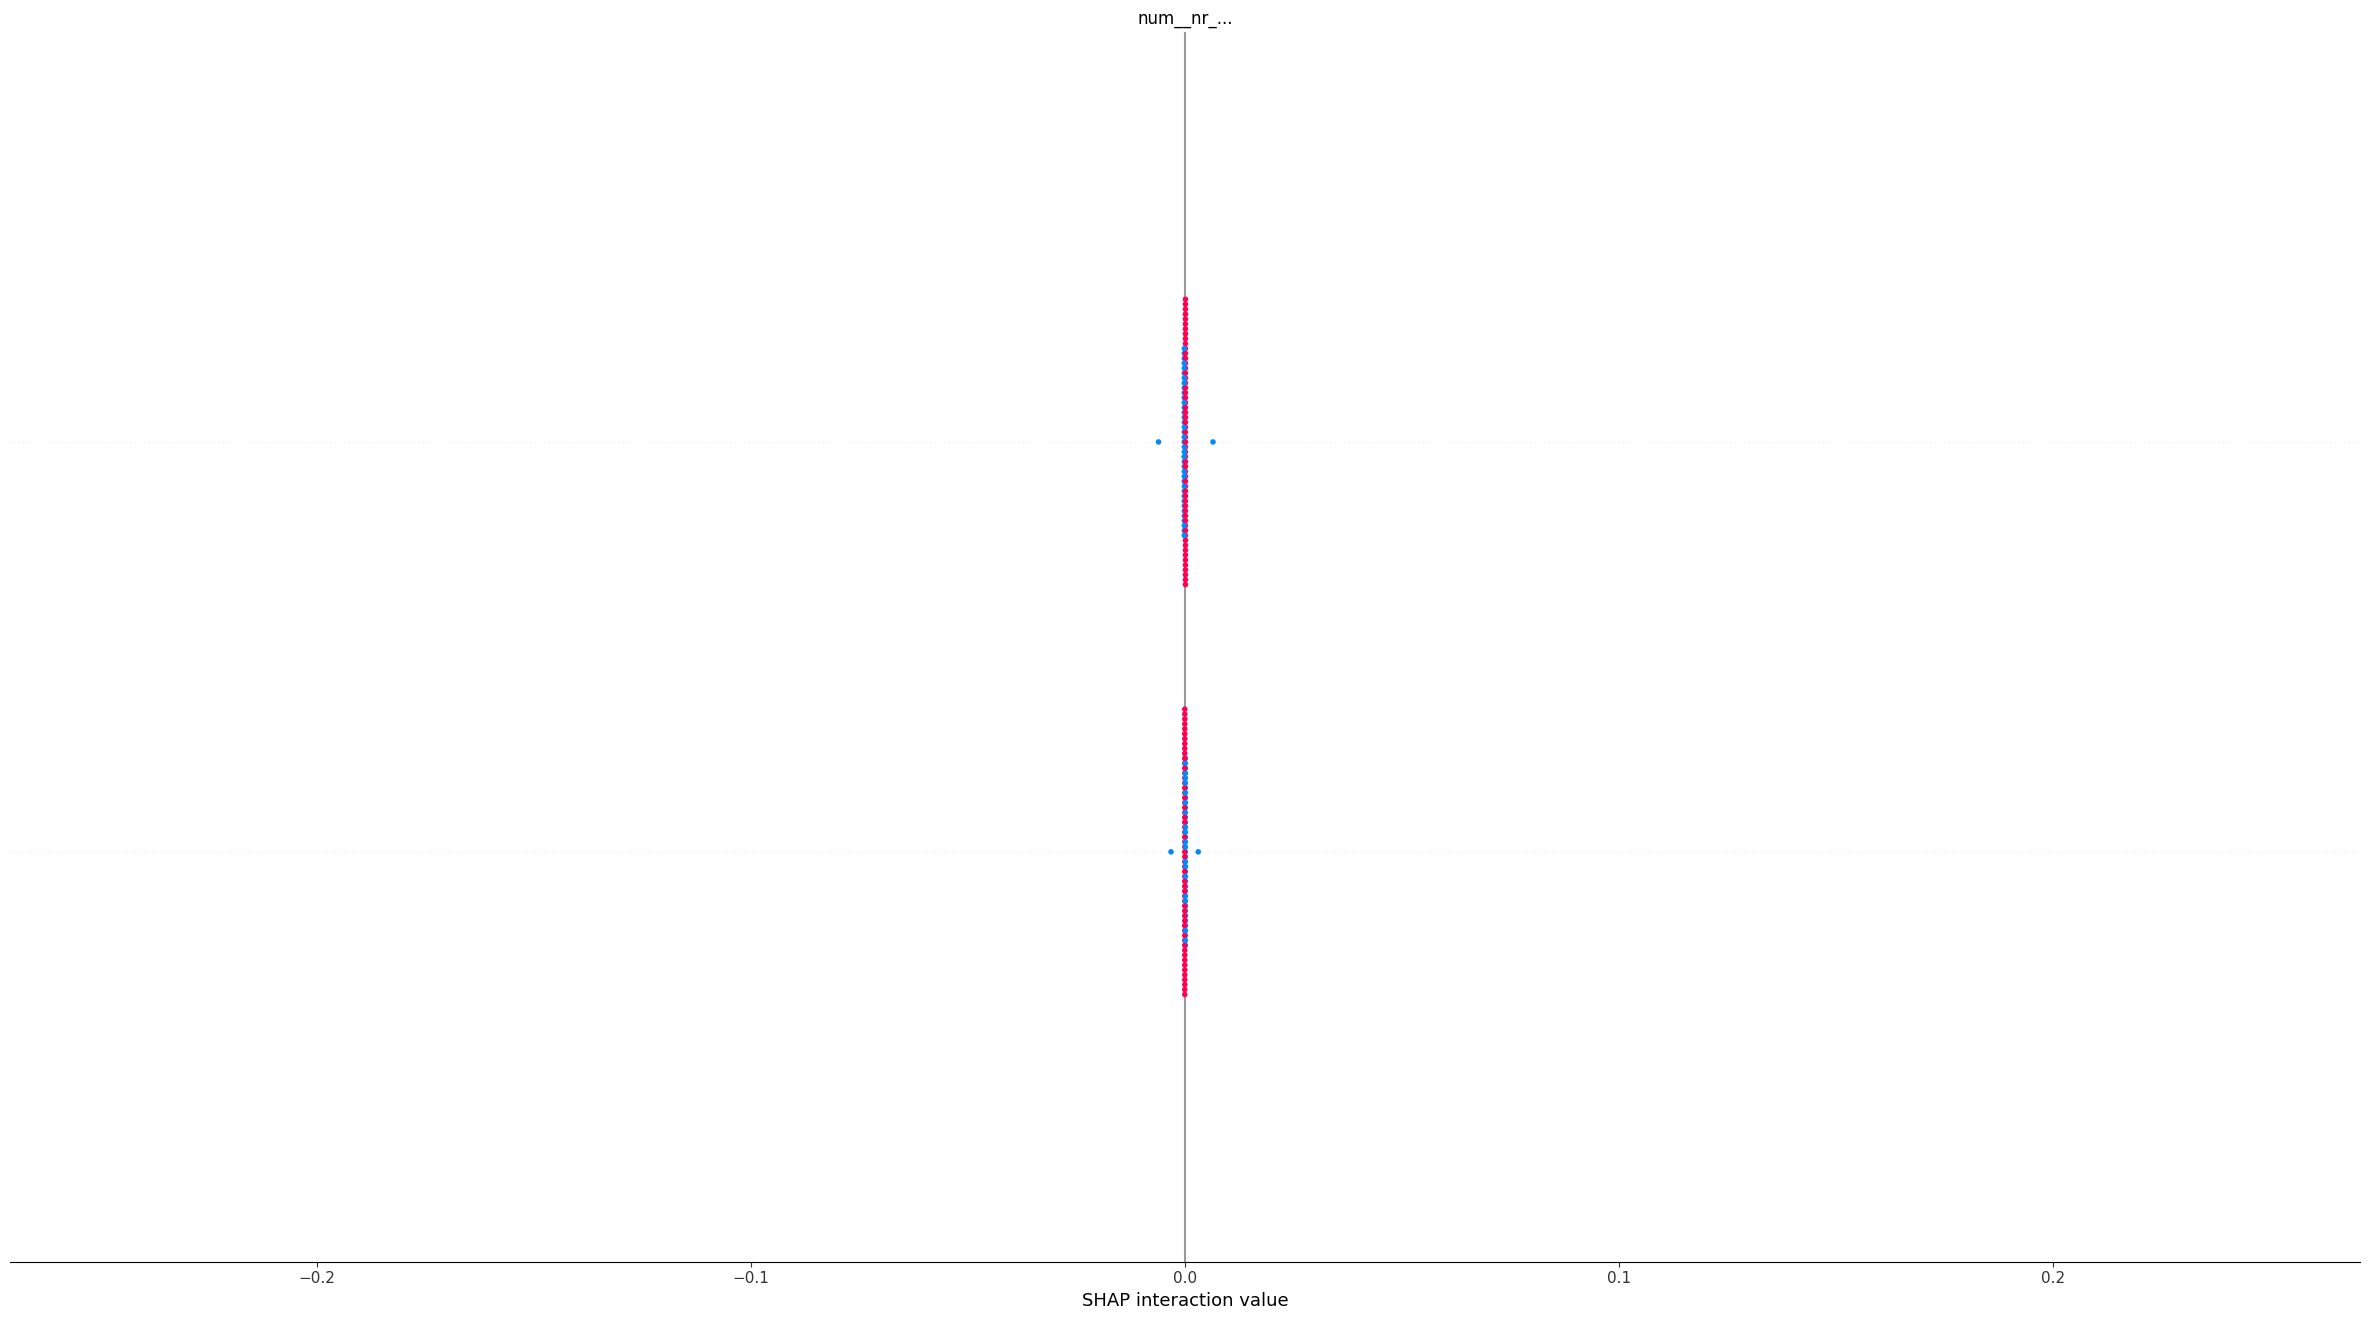

In [17]:
# SHAP exige uma amostra pequena
explainer = shap.Explainer(model_rf.named_steps['clf'], preprocessor.transform(X_train[:100]))
shap_values = explainer(preprocessor.transform(X_train[:100]))

# Gráfico
shap.summary_plot(shap_values, feature_names=preprocessor.get_feature_names_out(), max_display=15)


In [19]:
"""# Exportar modelo
joblib.dump(model_rf, "modelo_random_forest.pkl")
model_nn.save("modelo_rede_neural.h5")
joblib.dump(preprocessor, "preprocessador.pkl")

print("Modelos exportados com sucesso!")"""


'# Exportar modelo\njoblib.dump(model_rf, "modelo_random_forest.pkl")\nmodel_nn.save("modelo_rede_neural.h5")\njoblib.dump(preprocessor, "preprocessador.pkl")\n\nprint("Modelos exportados com sucesso!")'